## ライブラリのインポート

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sudachipy import dictionary, tokenizer
from tqdm import tqdm

## データの読み込み

In [3]:
# プロジェクトデータの読み込み
project_df = pd.read_csv("../data/raw/project-true.csv")
print(f"プロジェクトデータ: {len(project_df)}件")
print(project_df.head())

# ユーザー職歴データの読み込み
user_df = pd.read_csv(
    "../data/raw/user_work_histories.csv",
    usecols=["user_id", "project_name", "description", "role"],
)
print(f"\nユーザー職歴データ: {len(user_df)}件")
print(user_df.head())

プロジェクトデータ: 1000件
   id          name                                        description  \
0   1    旅行予約システム設計  当プロジェクトでは運用保守、テスト、デプロイ、ドキュメント作成、自動テスト導入やインフラ構築...   
1   2    予約管理システム設計  現プロジェクトにおいてデータベース設計やデプロイなどに取り組んでいる。\n[実施内容]\nデ...   
2   3  ブロックチェーン開発実装  要件定義、要件分析、パフォーマンス改善、自動テスト導入、クラウド移行やセキュリティ強化などの...   
3   4    動画配信サービス改善  技術選定、UI/UX設計、セキュリティ強化、実装、デプロイやデータベース設計などの開発に取り...   
4   5    物流管理システム改善             データベース設計、運用保守やチームマネジメントなどの開発に取り組んでいます。   

   start_date end_date  
0  2024-04-09      NaN  
1  2024-12-22      NaN  
2  2025-05-20      NaN  
3  2024-11-24      NaN  
4  2024-02-22      NaN  

ユーザー職歴データ: 911件
   user_id project_name                                        description  \
0        1     スマホアプリ開発    SNSアプリ開発\n[主な担当]\nドキュメント作成\nテスト実施\nインフラ構築\n技術検証   
1        1   医療情報システム開発  オンプレミス環境からAWSへのクラウド移行を主導しました。 新技術の調査やPoCを行い、アー...   
2        1   データ分析基盤の構築  アジャイル手法で開発を進め、定期的なスプリントレビューで改善を行いました。 自動テストの導入...   
3        1   動画配信サービス構築  セキュリティ強化プロジェクト\n[主な担当]\n要件定義\nパフォー

## 名詞抽出関数の定義

In [4]:
def extract_nouns(text: str):
    """
    テキストから名詞を抽出する関数
    """
    if pd.isna(text):
        return []

    # full辞書を使用して辞書オブジェクトを生成
    tokenizer_obj = dictionary.Dictionary(dict="full").create()
    # 形態素解析の粒度設定(C: 最も粗い)
    mode = tokenizer.Tokenizer.SplitMode.C

    # 形態素解析を実行
    morphemes = tokenizer_obj.tokenize(str(text), mode)

    nouns = []
    for m in morphemes:
        # 品詞情報を取得
        pos = m.part_of_speech()[0]
        if pos == "名詞":
            nouns.append(m.surface())
    return nouns


# 動作確認
sample_text = "AWSを使ったWebアプリケーション開発プロジェクト"
print(f"サンプルテキスト: {sample_text}")
print(f"抽出された名詞: {extract_nouns(sample_text)}")

サンプルテキスト: AWSを使ったWebアプリケーション開発プロジェクト
抽出された名詞: ['AWS', 'Web', 'アプリケーション', '開発', 'プロジェクト']


## Word2Vec用のコーパス作成

In [5]:
def create_corpus_from_df(df, columns, desc="Processing"):
    """
    DataFrameから指定列のテキストを抽出し、名詞のみのリストのリストを作成

    Parameters:
    -----------
    df : pd.DataFrame
        対象のDataFrame
    columns : list
        テキスト抽出対象の列名リスト
    desc : str
        進行状況バーの説明文

    Returns:
    --------
    corpus : list of list
        各行の名詞リスト
    """
    corpus = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=desc):
        # 各行の指定列から名詞を抽出
        row_nouns = []
        for col in columns:
            if col in df.columns and pd.notna(row[col]):
                nouns = extract_nouns(str(row[col]))
                row_nouns.extend(nouns)

        if row_nouns:  # 空でない場合のみ追加
            corpus.append(row_nouns)

    return corpus


# プロジェクトデータのコーパスを作成
print("プロジェクトデータの処理中...")
project_columns = ["name", "description"]
project_corpus = create_corpus_from_df(
    project_df, project_columns, desc="プロジェクトデータ"
)

# ユーザー職歴のコーパスを作成
print("\nユーザー職歴データの処理中...")
user_columns = ["project_name", "description", "role"]
user_corpus = create_corpus_from_df(user_df, user_columns, desc="ユーザー職歴データ")

# 両方を結合
corpus = project_corpus + user_corpus

print(f"\n✓ プロジェクトデータコーパス: {len(project_corpus)}件")
print(f"✓ ユーザー職歴コーパス: {len(user_corpus)}件")
print(f"✓ 結合コーパス: {len(corpus)}件")

print("\n【プロジェクトデータ】最初の2件のサンプル:")
for i, doc in enumerate(project_corpus[:2]):
    print(f"{i + 1}: {doc[:15]}...")

print("\n【ユーザー職歴データ】最初の2件のサンプル:")
for i, doc in enumerate(user_corpus[:2]):
    print(f"{i + 1}: {doc[:15]}...")

プロジェクトデータの処理中...


プロジェクトデータ: 100%|██████████| 1000/1000 [00:27<00:00, 36.71it/s]



ユーザー職歴データの処理中...


ユーザー職歴データ: 100%|██████████| 911/911 [00:36<00:00, 24.97it/s]


✓ プロジェクトデータコーパス: 1000件
✓ ユーザー職歴コーパス: 911件
✓ 結合コーパス: 1911件

【プロジェクトデータ】最初の2件のサンプル:
1: ['旅行', '予約', 'システム設計', 'プロジェクト', '運用', '保守', 'テスト', 'デプロイ', 'ドキュメント', '作成', '自動', 'テスト', '導入', 'インフラ', '構築']...
2: ['予約', '管理', 'システム設計', 'プロジェクト', 'データベース設計', 'デプロイ', '実施', '内容', 'データベース設計', 'デプロイ', '実装', '自動', 'テスト', '導入', '運用']...

【ユーザー職歴データ】最初の2件のサンプル:
1: ['スマホアプリ', '開発', 'SNS', 'アプリ', '開発', '担当', 'ドキュメント', '作成', 'テスト', '実施', 'インフラ', '構築', '技術', '検証', 'プログラマー']...
2: ['医療情報システム', '開発', 'オンプレミス', '環境', 'AWS', 'クラウド', '移行', '主導', '新技術', '調査', 'PoC', 'アーキテクチャ', '改善', '提案', 'バックエンド']...


## コーパスの統計情報

In [6]:
# 全単語の頻度を集計
all_words = [word for doc in corpus for word in doc]
word_freq = Counter(all_words)

print(f"総単語数: {len(all_words):,}")
print(f"ユニーク単語数: {len(word_freq):,}")

print("\n頻出単語 上位30:")
for i, (word, count) in enumerate(word_freq.most_common(30), 1):
    print(f"{i:2d}. {word}: {count:,}回")

総単語数: 32,852
ユニーク単語数: 193

頻出単語 上位30:
 1. 開発: 1,116回
 2. 構築: 1,026回
 3. 設計: 993回
 4. プロジェクト: 892回
 5. テスト: 870回
 6. 担当: 805回
 7. 改善: 739回
 8. 実装: 634回
 9. レビュー: 525回
10. クラウド: 510回
11. 導入: 498回
12. チーム: 492回
13. システム設計: 415回
14. セキュリティ: 415回
15. 移行: 413回
16. UI: 408回
17. UX: 408回
18. 要件: 404回
19. 技術: 398回
20. パフォーマンス: 388回
21. マネジメント: 388回
22. リファクタリング: 381回
23. データベース設計: 369回
24. 要件定義: 369回
25. アーキテクチャ: 341回
26. アプリ: 333回
27. 運用: 327回
28. 強化: 327回
29. 保守: 321回
30. システム: 307回


## Word2Vecモデルの学習

In [7]:
# Word2Vecモデルの学習
model = Word2Vec(
    sentences=corpus,  # 学習データ
    vector_size=100,  # ベクトルの次元数
    window=5,  # コンテキストウィンドウのサイズ
    min_count=2,  # 最小出現回数（これ以下の単語は無視）
    sg=1,  # 0: CBOW, 1: Skip-gram
    epochs=100,  # エポック数
    negative=5,  # ネガティブサンプリング数（Skip-gram使用時）
    alpha=0.025,  # 初期学習率
    min_alpha=0.0001,  # 最小学習率
    seed=42,  # 再現性のため
)

print(f"語彙数: {len(model.wv):,}語")
print(f"ベクトルの次元数: {model.wv.vector_size}")
print("学習完了")

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


語彙数: 193語
ベクトルの次元数: 100
学習完了


## モデルの保存

In [8]:
# モデルの保存
model.save("../models/word2vec_true_model.bin")
print("モデルを保存しました: ../models/word2vec_true_model.bin")

# 単語ベクトルのみを保存（より軽量）
model.wv.save("../models/word2vec_true_vectors.kv")
print("単語ベクトルを保存しました: ../models/word2vec_true_vectors.kv")

モデルを保存しました: ../models/word2vec_true_model.bin
単語ベクトルを保存しました: ../models/word2vec_true_vectors.kv


## 単語ベクトルの確認

In [9]:
# 単語ベクトルの確認
test_words = ["開発", "システム", "AWS", "React", "Python", "設計", "テスト"]

print("単語ベクトルの確認:")
for word in test_words:
    if word in model.wv:
        vector = model.wv[word]
        print(f"\n単語: {word}")
        print(f"  ベクトル (最初の10次元): {vector[:10]}")
        print(f"  ベクトルの形状: {vector.shape}")
    else:
        print(f"\n単語 '{word}' は語彙に含まれていません")

単語ベクトルの確認:

単語: 開発
  ベクトル (最初の10次元): [-0.30571228 -0.34591103 -0.05384196  0.06702629 -0.03939138  0.13428147
 -0.22122124  0.39897385 -0.51092356 -0.08373719]
  ベクトルの形状: (100,)

単語: システム
  ベクトル (最初の10次元): [ 0.12203261 -0.16602406 -0.00222226  0.42883512  0.22186352  0.46520594
 -0.05318914  0.39361975 -0.46045378  0.17832215]
  ベクトルの形状: (100,)

単語: AWS
  ベクトル (最初の10次元): [ 0.01001425  0.39195785 -0.23933613 -0.22648227 -0.13303354 -0.2017797
 -0.83045423 -0.11414646 -0.55342495  0.4774313 ]
  ベクトルの形状: (100,)

単語: React
  ベクトル (最初の10次元): [ 0.02702176 -0.2723099  -0.25258604 -0.32987925 -0.18705218  0.29775274
  0.0661417   0.20795415 -0.22074914  0.6757678 ]
  ベクトルの形状: (100,)

単語 'Python' は語彙に含まれていません

単語: 設計
  ベクトル (最初の10次元): [ 0.08241554 -0.27723888  0.05399457  0.13000032  0.07273976 -0.2057114
  0.00070056  0.10713929 -0.2235467   0.09011707]
  ベクトルの形状: (100,)

単語: テスト
  ベクトル (最初の10次元): [ 0.01079298 -0.07131372 -0.33485743  0.04835778 -0.11479665  0.23036198
 -0.05753871  0.10760083

## 類似単語の検索

In [10]:
# 類似単語の検索
test_words = ["AWS", "React", "リーダー", "開発", "テスト"]

for test_word in test_words:
    if test_word in model.wv:
        similar_words = model.wv.most_similar(test_word, topn=10)
        print(f"\n'{test_word}' に類似する単語:")
        for word, similarity in similar_words:
            print(f"  {word}: {similarity:.4f}")
    else:
        print(f"\n単語 '{test_word}' は語彙に含まれていません")


'AWS' に類似する単語:
  主導: 0.5944
  オンプレミス: 0.5831
  環境: 0.5539
  パイプライン: 0.4451
  新技術: 0.4440
  課題: 0.4419
  A: 0.4360
  調査: 0.4349
  マスター: 0.4343
  ユーザビリティテスト: 0.4328

'React' に類似する単語:
  SPA: 0.6384
  Vue: 0.6149
  アジャイル: 0.4738
  環境: 0.4507
  複数: 0.4504
  手法: 0.4498
  ユーザビリティテスト: 0.4487
  チームメンバー: 0.4480
  新技術: 0.4475
  スプリント: 0.4442

'リーダー' に類似する単語:
  テスター: 0.6984
  システムエンジニア: 0.6936
  PM: 0.6785
  SWE: 0.6666
  プログラマー: 0.6569
  SE: 0.6279
  PG: 0.6081
  エンジニア: 0.6030
  デザイナー: 0.5632
  インフラエンジニア: 0.5591

'開発' に類似する単語:
  レビュー: 0.4066
  要件定義: 0.3745
  動画配信サービス: 0.3741
  ECサイト: 0.3306
  リニューアル: 0.3292
  アプリ: 0.3237
  データベース設計: 0.3225
  教育: 0.3217
  データ分析: 0.3026
  技術: 0.3020

'テスト' に類似する単語:
  要件定義: 0.4781
  UI: 0.4439
  UX: 0.4429
  リファクタリング: 0.3878
  保守: 0.3685
  データ分析: 0.3337
  設計: 0.3336
  短縮: 0.3194
  自動: 0.3133
  顧客管理: 0.3126


## 単語間の類似度計算

In [11]:
# 単語間の類似度を計算
word_pairs = [
    ("AWS", "GCP"),
    ("React", "Vue"),
    ("開発", "構築"),
    ("設計", "実装"),
    ("プログラミング", "開発"),
    ("テスト", "デバッグ"),
]

print("単語間の類似度:")
for word1, word2 in word_pairs:
    if word1 in model.wv and word2 in model.wv:
        similarity = model.wv.similarity(word1, word2)
        print(f"  {word1} - {word2}: {similarity:.4f}")
    else:
        missing = []
        if word1 not in model.wv:
            missing.append(word1)
        if word2 not in model.wv:
            missing.append(word2)
        print(f"  {word1} - {word2}: 語彙に含まれていない単語: {', '.join(missing)}")

単語間の類似度:
  AWS - GCP: 語彙に含まれていない単語: GCP
  React - Vue: 0.6149
  開発 - 構築: 0.2894
  設計 - 実装: 0.4735
  プログラミング - 開発: 0.2100
  テスト - デバッグ: 0.1082


## 単語ベクトルをCSVに保存

In [12]:
# 全単語のベクトルをDataFrameに変換して保存
word_vectors_df = pd.DataFrame(
    [model.wv[word] for word in model.wv.index_to_key], index=model.wv.index_to_key
)

# CSVに保存
word_vectors_df.to_csv("../outputs/word_vectors_true.csv")
print("単語ベクトルをCSVに保存しました: ../outputs/word_vectors_true.csv")
print(f"形状: {word_vectors_df.shape}")
print("\n最初の5単語:")
print(word_vectors_df.head())

単語ベクトルをCSVに保存しました: ../outputs/word_vectors_true.csv
形状: (193, 100)

最初の5単語:
              0         1         2         3         4         5         6   \
開発     -0.305712 -0.345911 -0.053842  0.067026 -0.039391  0.134281 -0.221221   
構築     -0.108593 -0.587756  0.263049 -0.204771  0.195090  0.138731  0.048234   
設計      0.082416 -0.277239  0.053995  0.130000  0.072740 -0.205711  0.000701   
プロジェクト  0.126908 -0.356346 -0.482172 -0.002937  0.210131  0.060908 -0.434278   
テスト     0.010793 -0.071314 -0.334857  0.048358 -0.114797  0.230362 -0.057539   

              7         8         9   ...        90        91        92  \
開発      0.398974 -0.510924 -0.083737  ...  0.051866  0.193077  0.119958   
構築      0.252413 -0.167609  0.158110  ...  0.000447  0.494645  0.080098   
設計      0.107139 -0.223547  0.090117  ... -0.081052  0.273795  0.344328   
プロジェクト  0.277374 -0.043643 -0.045220  ...  0.093093  0.062383  0.103082   
テスト     0.107601 -0.167852  0.080730  ... -0.046086  0.288421  0.058

## t-SNEによる単語ベクトルの可視化

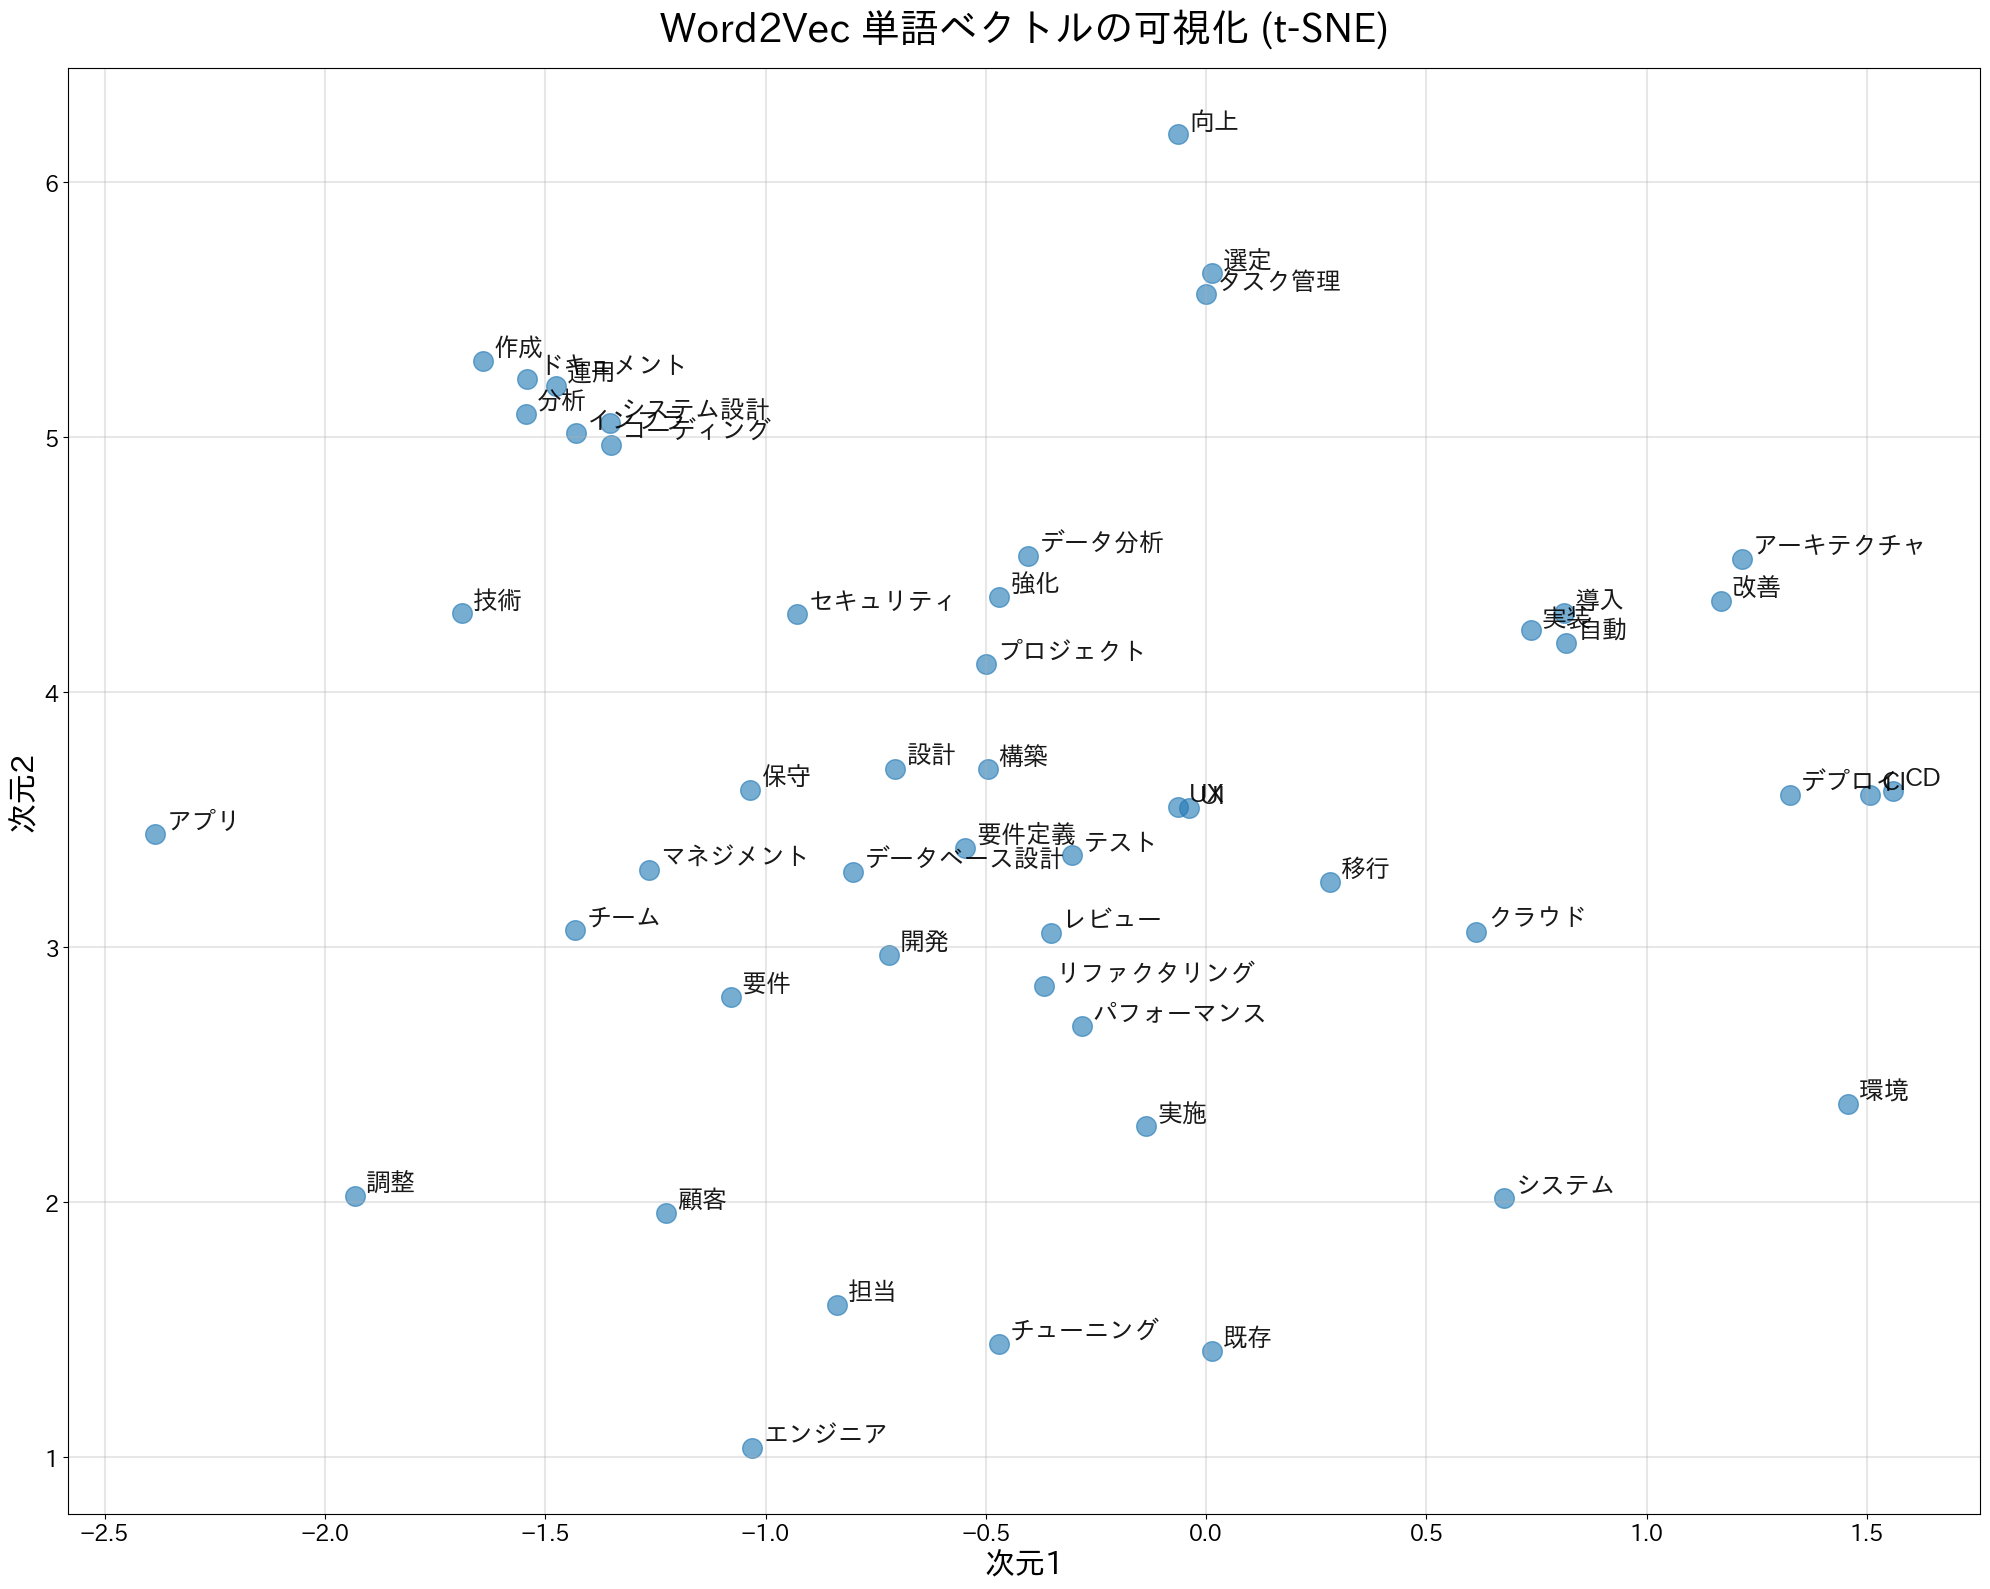

可視化した単語数: 50


In [14]:
# 頻出単語上位50件を可視化
top_words = [word for word, _ in word_freq.most_common(50)]
top_words_in_model = [word for word in top_words if word in model.wv]

# ベクトルを取得
vectors = np.array([model.wv[word] for word in top_words_in_model])

# t-SNEで2次元に圧縮
tsne = TSNE(
    n_components=2, random_state=42, perplexity=min(30, len(top_words_in_model) - 1)
)
vectors_2d = tsne.fit_transform(vectors)

# フォント設定
plt.rcParams["font.family"] = "IPAexGothic"

# 可視化
plt.figure(figsize=(20, 16))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.6, s=200)

# 単語ラベルを追加
for i, word in enumerate(top_words_in_model):
    plt.annotate(
        word,
        xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
        xytext=(8, 4),
        textcoords="offset points",
        fontsize=18,
        fontweight="bold",
        alpha=0.9,
    )

plt.title(
    "Word2Vec 単語ベクトルの可視化 (t-SNE)", fontsize=28, fontweight="bold", pad=20
)
plt.xlabel("次元1", fontsize=22, fontweight="bold")
plt.ylabel("次元2", fontsize=22, fontweight="bold")
plt.tick_params(labelsize=16)
plt.grid(True, alpha=0.3, linewidth=1.5)
plt.tight_layout()
plt.show()

print(f"可視化した単語数: {len(top_words_in_model)}")